In [1]:
%load_ext autoreload
%autoreload 2
import HammingCode
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc
import NeuralNetworkCorrection as network
import Autoencoder
import Utils

2024-05-25 13:57:00.393700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 13:57:00.393819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 13:57:00.396243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 13:57:00.408856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 13:57:02.874795: W tensorflow/compiler/tf2

In [2]:
# tamanho da amostra
tamanho = 1e8
variancia = 1

# amostra
tamanho_amostra = 10**3
Eb_dB_values = np.arange(-2, 11, 1)

# ML data

# Gerar dados de treinamento
word_length = 4 # Tamanho padrão da entrada do hamming
training_sample_length = 10 **3
epoches = 50
training_noisy_data = []
training_original_data = []
batch_size = 32
''''
training_data = {
    'original': [],
    'noisy': [],
    'info': []
}
training_information = network.get_training_data_set(training_sample_length, variancia)

for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(training_information, eb_db)
    training_data['info'].append(info)
    training_data['noisy'].extend(info['split_encoded_data'])
    training_data['original'].extend(info['split_original_data'])

training_data['original'] = np.array(training_data['original'])
training_data['noisy'] = np.array(training_data['noisy'])
'''

"'\ntraining_data = {\n    'original': [],\n    'noisy': [],\n    'info': []\n}\ntraining_information = network.get_training_data_set(training_sample_length, variancia)\n\nfor eb_db in Eb_dB_values:\n    info = network.generate_data_for_training(training_information, eb_db)\n    training_data['info'].append(info)\n    training_data['noisy'].extend(info['split_encoded_data'])\n    training_data['original'].extend(info['split_original_data'])\n\ntraining_data['original'] = np.array(training_data['original'])\ntraining_data['noisy'] = np.array(training_data['noisy'])\n"

In [ ]:
# Criar e treinar a rede neural
model = network.train_neural_network(training_data, epoches, batch_size)
autoencoder = Autoencoder.create_and_train_auto_encoder(training_data, epoches, batch_size)

In [5]:
# Gerar dados de teste
amostras_ruidosas = []
amostras_originais = []
ML_result = []
tradicional_result = []
autoencoder_result = []


In [15]:
test_data = {
    'original': [],
    'info': []
}
test_sample_length = 10 ** 3
test_information = network.get_training_data_set(test_sample_length)

for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(test_information, eb_db, variancia)
    test_data['info'].append(info)
    test_data['original'] = info['original_data']


In [ ]:
i = 0
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))

In [ ]:
i = 1
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [ ]:
i = 2
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [ ]:
i = 3
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [ ]:
i = 4
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [ ]:
i = 5
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [ ]:
i = 6
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [ ]:
i = 7
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [ ]:
i = 8
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [ ]:
i = 9
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [ ]:
i = 10
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [ ]:
i = 11
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [ ]:
i = 12
autoencoder_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], autoencoder))
ML_result.append(network.decode_and_correct(test_data['info'][i]['split_encoded_data'], model))
tradicional_result.append(HammingCode.decode_sample(test_data['info'][i]['split_encoded_data']))


In [16]:
for i in test_data['info']:
    tradicional_result.append(HammingCode.decode_sample(i['split_encoded_data']))

In [17]:
BER_tradicional = []
BER_autoencoder = []
BER_ML = []
for i in range(0, len(Eb_dB_values)):
    #BER_ML.append(np.sum(np.array(ML_result[i]).astype(int) != test_data['original']) / len(test_data['original']))
    BER_tradicional.append(np.sum(np.array(tradicional_result[i]).astype(int) != test_data['original']) / len(test_data['original']))
    #BER_autoencoder.append(np.sum(np.array(autoencoder_result[i]).astype(int) != test_data['original']) / len(test_data['original']))

print(BER_tradicional)
# Calcular a BER teórica
Eb_values = 10**(Eb_dB_values / 10)
BER_teorica = 0.5 * erfc(np.sqrt(Eb_values))

[0.472, 0.453, 0.494, 0.479, 0.455, 0.476, 0.49, 0.472, 0.484, 0.495, 0.468, 0.463, 0.482]


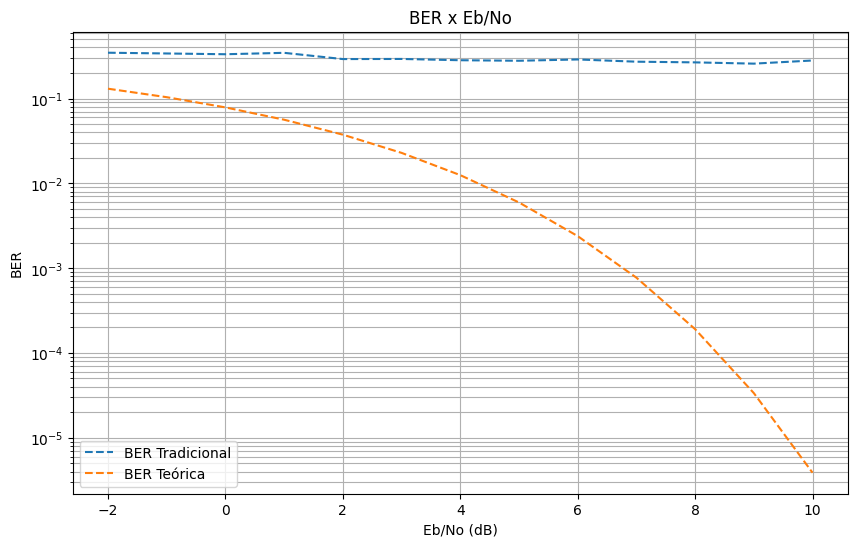

In [10]:
# Plotar as taxas de erro de bit simuladas e teóricas
plt.figure(figsize=(10, 6))
plt.semilogy(Eb_dB_values, BER_tradicional, linestyle = '--', label='BER Tradicional')
#plt.semilogy(Eb_dB_values, BER_autoencoder, linestyle = '--', label='BER Autoencoder')
#plt.semilogy(Eb_dB_values, BER_ML, linestyle = '--', label='BER ML')
plt.semilogy(Eb_dB_values, BER_teorica, linestyle='--', label='BER Teórica')
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.grid(True, which='both')
plt.legend()
plt.title('BER x Eb/No')
plt.show()